<a href="https://colab.research.google.com/github/ericodle/PhyloGreg/blob/main/fully_connected_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install biopython
!pip install dendropy

import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from Bio import SeqIO

import matplotlib.pyplot as plt

import pickle

import numpy as np

from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import dendropy


# Specify the CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor_sequences = torch.load('/content/drive/MyDrive/tensor_sequences.pt').to(device)
tensor_labels = torch.load('/content/drive/MyDrive/tensor_labels.pt').to(device)

# Create a TensorDataset
dataset = TensorDataset(tensor_sequences)

# Create a DataLoader
batch_size = 10000  
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 kB 9.6 MB/s eta 0:00:00


In [74]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh((2 / np.pi) ** 0.5 * (x + 0.044715 * torch.pow(x, 3))))

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, input_size)
        self.gelu = nn.GELU()

    def forward(self, x):
        out = self.gelu(self.fc1(x))
        out = self.gelu(self.fc2(out))
        out = self.fc3(out)
        return out

# Define the input size, hidden size, and output size
input_size = 2048

In [63]:
# Instantiate the model
model = MLP(input_size)

# Specify the CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to CUDA
model.to(device)

# Print the model architecture
print(model)

MLP(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2048, bias=True)
  (gelu): GELU(approximate='none')
)


In [75]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Adjust based on your task

optimizer = optim.SGD(model.parameters(), lr=0.01)

# Define cyclic learning rate scheduler
#scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, mode='triangular', cycle_momentum=False)

# Define cosine annealing learning rate scheduler
#scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# Define the OneCycleLR learning rate scheduler
scheduler = OneCycleLR(optimizer, max_lr=0.1, total_steps=num_epochs, pct_start=0.2, anneal_strategy='cos')

num_epochs = 1000000

In [65]:
train_losses = []
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    for data in train_loader:
        # Extract the inputs (unsupervised, so no labels)
        inputs = torch.stack(data)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)  # Using inputs as targets for reconstruction loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update cyclic learning rate
        scheduler.step()

    train_losses.append(loss.item())
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    
    # Check stopping condition
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print("Stopping condition met. Training stopped.")
            break

Epoch [1/1000000], Loss: 5.25637674331665
Epoch [2/1000000], Loss: 1.641149640083313
Epoch [3/1000000], Loss: 1.4289335012435913
Epoch [4/1000000], Loss: 1.3903162479400635
Epoch [5/1000000], Loss: 1.3585760593414307
Epoch [6/1000000], Loss: 1.3528988361358643
Epoch [7/1000000], Loss: 1.344568133354187
Epoch [8/1000000], Loss: 1.3359007835388184
Epoch [9/1000000], Loss: 1.32639741897583
Epoch [10/1000000], Loss: 1.308537244796753
Epoch [11/1000000], Loss: 1.292515754699707
Epoch [12/1000000], Loss: 1.2703145742416382
Epoch [13/1000000], Loss: 1.2529176473617554
Epoch [14/1000000], Loss: 1.229001760482788
Epoch [15/1000000], Loss: 1.2091270685195923
Epoch [16/1000000], Loss: 1.1902573108673096
Epoch [17/1000000], Loss: 1.178276777267456
Epoch [18/1000000], Loss: 1.1642793416976929
Epoch [19/1000000], Loss: 1.1578495502471924
Epoch [20/1000000], Loss: 1.1482268571853638
Epoch [21/1000000], Loss: 1.14167058467865
Epoch [22/1000000], Loss: 1.1399911642074585
Epoch [23/1000000], Loss: 1.135

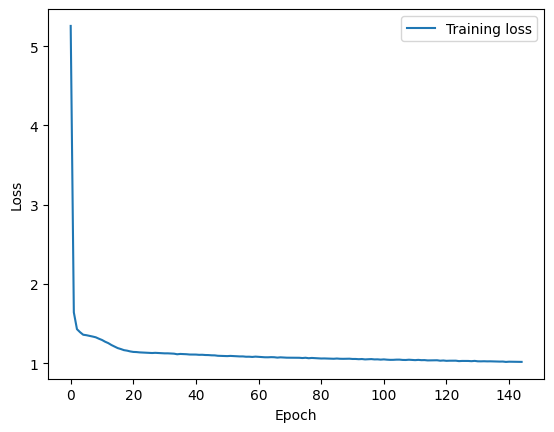

In [66]:
plt.plot(train_losses, label='Training loss')
#plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [67]:
torch.save(model.state_dict(), '/content/drive/MyDrive/mlp_model_state_dict.pth')

# Load it and analyze it

In [68]:
# Create an instance of the MLP model
model = MLP(input_size)

# Load the pre-trained model's state dictionary
model.load_state_dict(torch.load('/content/drive/MyDrive/mlp_model_state_dict.pth', map_location=torch.device('cpu')))

model

MLP(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2048, bias=True)
  (gelu): GELU(approximate='none')
)

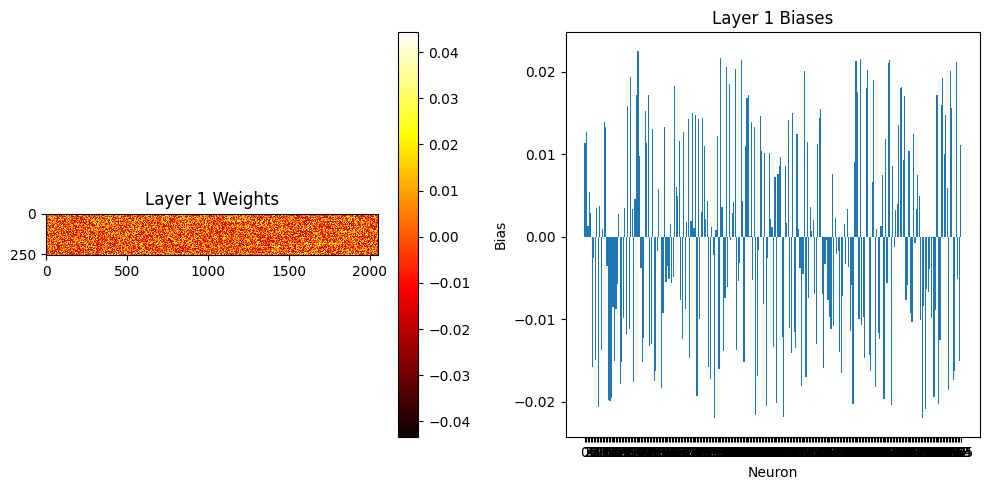

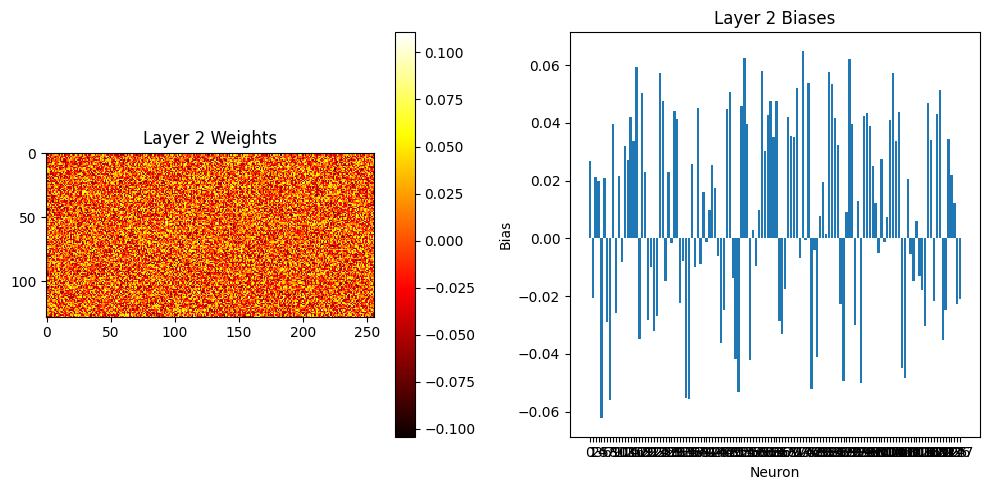

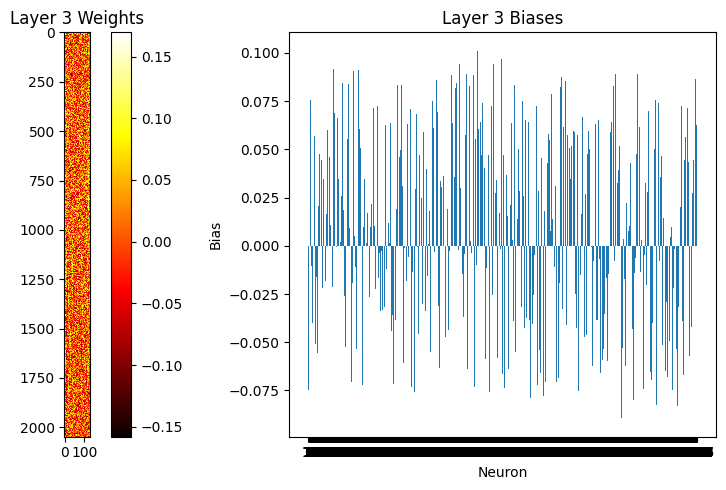

In [69]:
# Access the weights and biases of each layer
weights_fc1 = model.fc1.weight.data.numpy()
biases_fc1 = model.fc1.bias.data.numpy()

weights_fc2 = model.fc2.weight.data.numpy()
biases_fc2 = model.fc2.bias.data.numpy()

weights_fc3 = model.fc3.weight.data.numpy()
biases_fc3 = model.fc3.bias.data.numpy()

# Plotting the weights and biases
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Layer 1 Weights")
plt.imshow(weights_fc1, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.title("Layer 1 Biases")
plt.bar(range(len(biases_fc1)), biases_fc1)
plt.xticks(range(len(biases_fc1)))
plt.xlabel("Neuron")
plt.ylabel("Bias")

plt.tight_layout()
plt.show()

# Plotting the weights and biases
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Layer 2 Weights")
plt.imshow(weights_fc2, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.title("Layer 2 Biases")
plt.bar(range(len(biases_fc2)), biases_fc2)
plt.xticks(range(len(biases_fc2)))
plt.xlabel("Neuron")
plt.ylabel("Bias")

plt.tight_layout()
plt.show()

# Plotting the weights and biases
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Layer 3 Weights")
plt.imshow(weights_fc3, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.title("Layer 3 Biases")
plt.bar(range(len(biases_fc3)), biases_fc3)
plt.xticks(range(len(biases_fc3)))
plt.xlabel("Neuron")
plt.ylabel("Bias")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2048])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


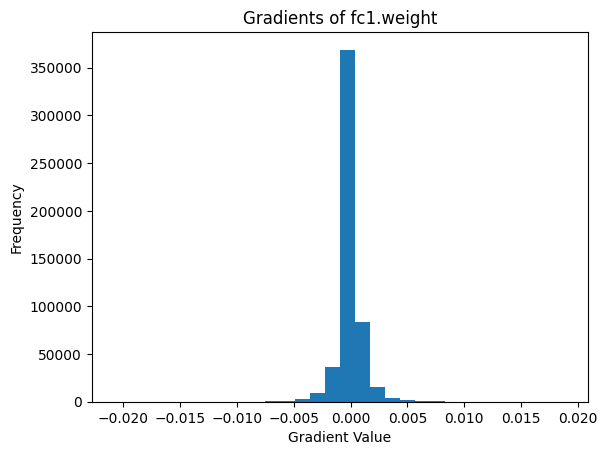

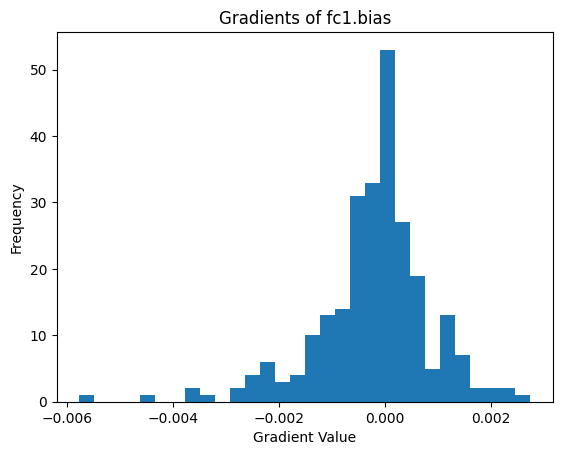

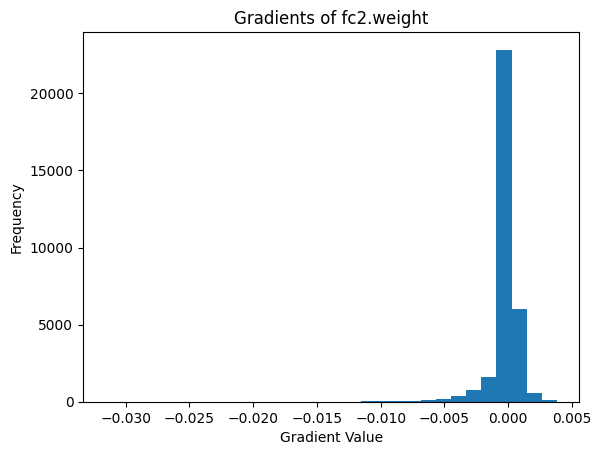

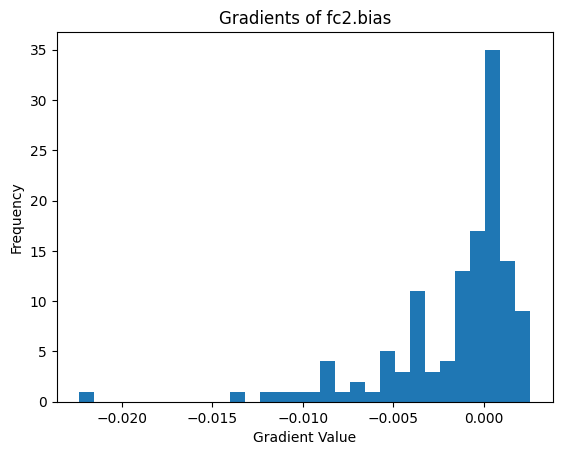

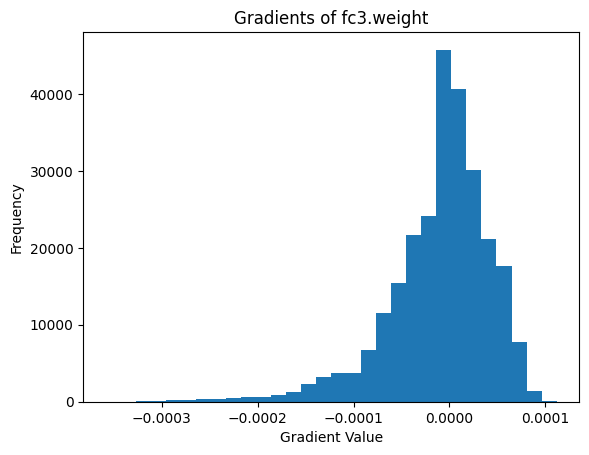

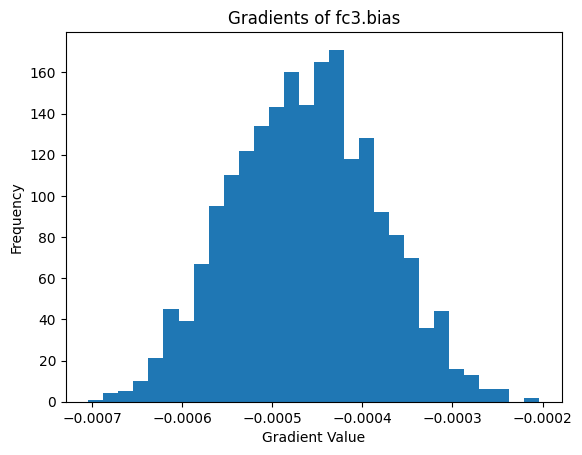

In [70]:
# Prepare the input tensor
input_tensor = torch.randn(1, input_size)

# Create a target value tensor (example)
target_tensor = torch.tensor([[0.5]])

# Compute the output tensor
output_tensor = model(input_tensor)

# Compute the loss between the output and target
loss = nn.MSELoss()(output_tensor, target_tensor)

# Perform backpropagation to compute gradients
loss.backward()

# Visualize the gradients at each level
for name, param in model.named_parameters():
    if param.grad is not None:
        plt.figure()
        plt.title(f"Gradients of {name}")
        plt.hist(param.grad.detach().numpy().flatten(), bins=30)
        plt.xlabel("Gradient Value")
        plt.ylabel("Frequency")
        plt.show()

## ANALYZE TRAINED MODEL

<ipython-input-71-379161790ffb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(greg_sequences, dtype=torch.float32)


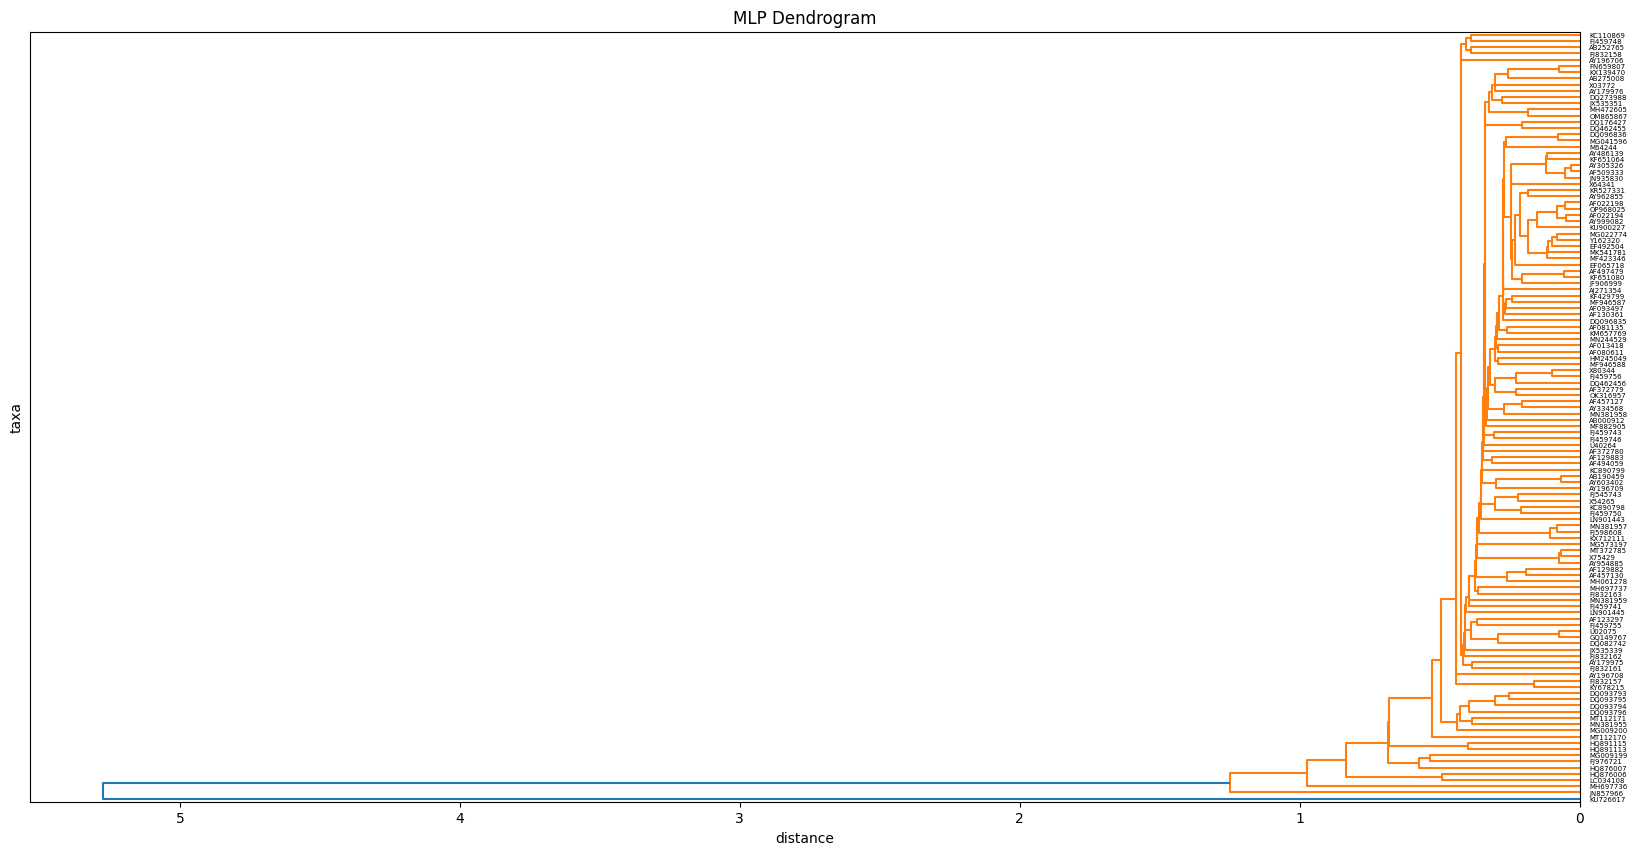

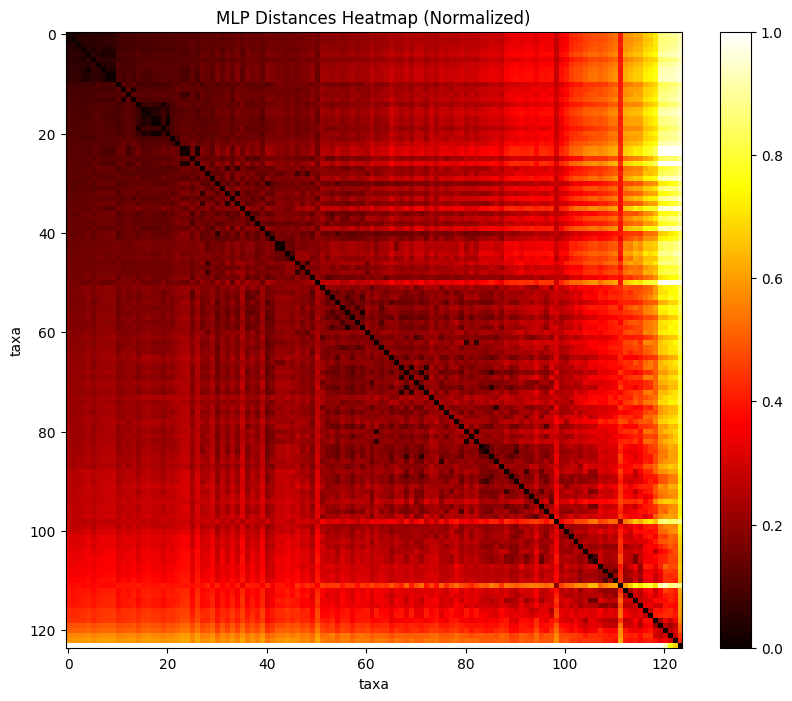

In [71]:
greg_sequences = torch.load("/content/drive/MyDrive/gregssu_preprocessed_sequences.pt")

# Convert the preprocessed sequences to a PyTorch tensor
input_data = torch.tensor(greg_sequences, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Get the outputs from the FC5 layer
mlp_outputs = model(input_data)

# Convert the outputs to a list
mlp_outputs_list = mlp_outputs.tolist()

# Load the sequence names from the file
with open("/content/drive/MyDrive/sequence_labels.pkl", "rb") as file:
    sequence_names = pickle.load(file)

# Convert vectors to a numpy array
mlp_outputs_array = np.array(mlp_outputs_list)

# Compute distance matrix
mlp_distances = pdist(mlp_outputs_array, metric='euclidean')

#Convert the distance array to a squareform distance matrix
mlp_distance_matrix = squareform(mlp_distances)

# Create a DataFrame from the condensed matrix
mlp_pd = pd.DataFrame(mlp_distance_matrix, index=sequence_names, columns=sequence_names)

#pad
mlp_pd = mlp_pd.fillna(0)

# Sort the DataFrame by row and column values
mlp_pd_sorted = mlp_pd.sort_values(by=sequence_names, axis=0).sort_values(by=sequence_names, axis=1)

# Normalize the values
scaler = MinMaxScaler()
mlp_pd_norm = pd.DataFrame(scaler.fit_transform(mlp_pd_sorted), index=mlp_pd_sorted.index, columns=mlp_pd_sorted.columns)

# Compute linkage matrix
mlp_linkage_matrix = hierarchy.linkage(mlp_pd_norm, method='single')

#Plot the dendrogram
plt.figure(figsize=(20, 10))
mlp_dendrogram = hierarchy.dendrogram(mlp_linkage_matrix, labels=sequence_names, orientation="left")
plt.title('MLP Dendrogram')
plt.xlabel('distance')
plt.ylabel('taxa')

plt.show()

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.imshow(mlp_pd_norm, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
plt.title('MLP Distances Heatmap (Normalized)')
plt.xlabel('taxa')
plt.ylabel('taxa')
plt.show()

# ANALYZE GROUND TRUTH TREE





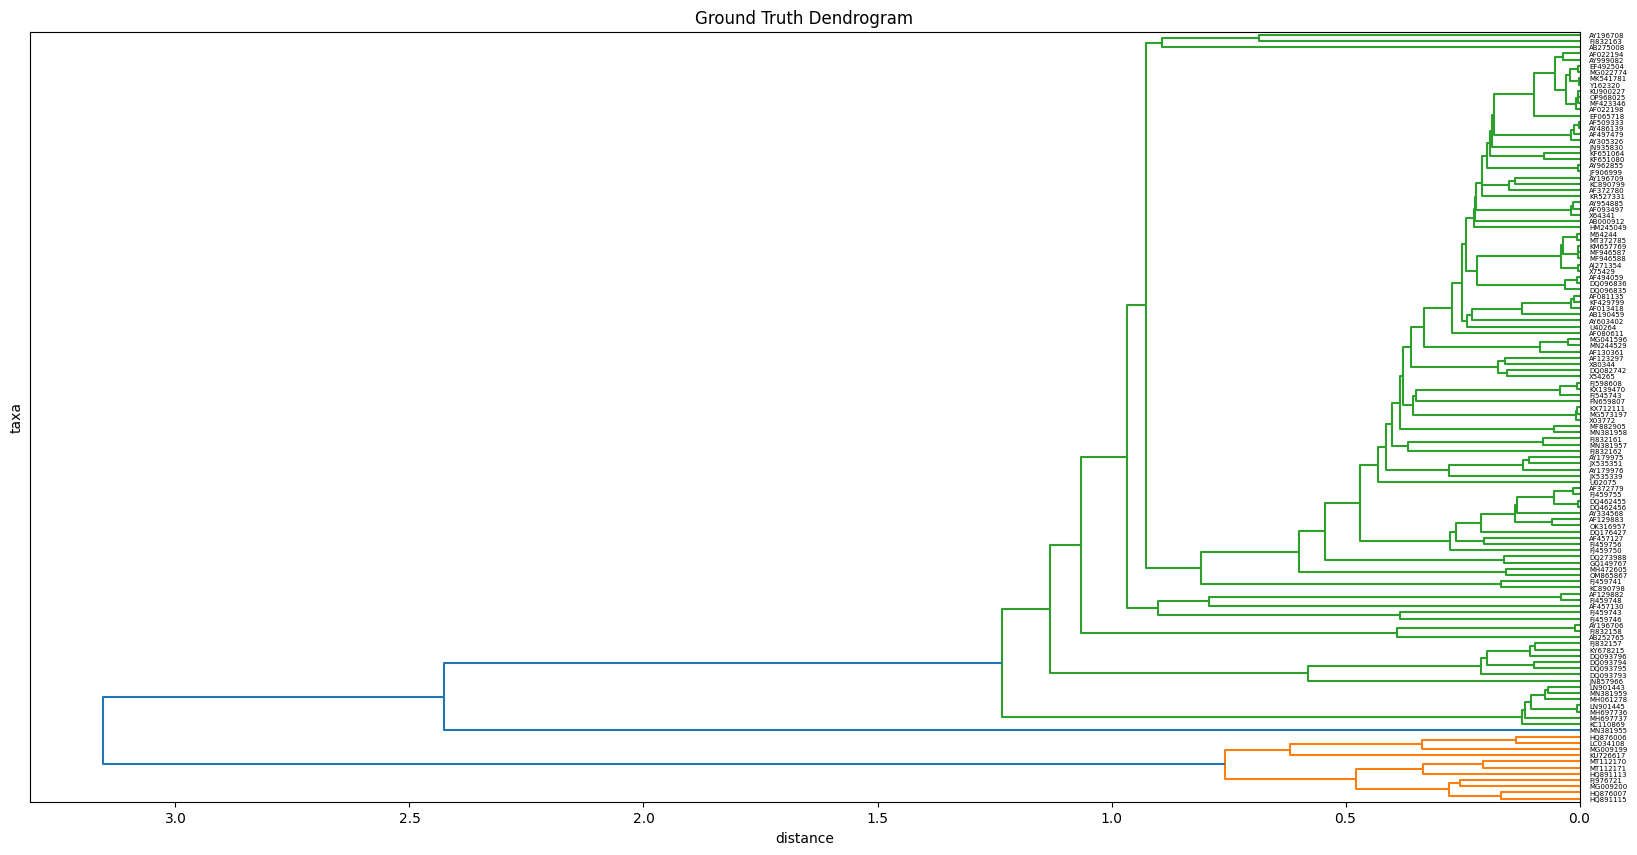

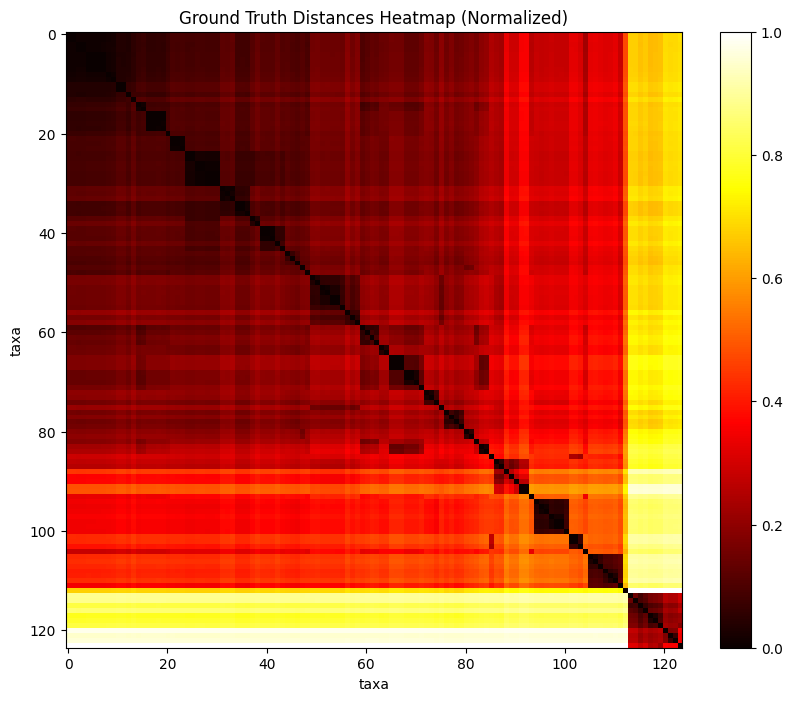

In [76]:
# Load the CSV file
greg_pd = pd.read_csv('/content/drive/MyDrive/gregssuraxmlpd.csv', index_col=0)

#pad
greg_pd = greg_pd.fillna(0)

# Sort the DataFrame by row and column values
greg_pd_sorted = greg_pd.sort_values(by=sequence_names, axis=0).sort_values(by=sequence_names, axis=1)

# Normalize the values
scaler = MinMaxScaler()
greg_pd_norm = pd.DataFrame(scaler.fit_transform(greg_pd), index=greg_pd.index, columns=greg_pd.columns)

# Compute linkage matrix
greg_linkage_matrix = hierarchy.linkage(greg_pd_norm, method='single')

#Plot the dendrogram
plt.figure(figsize=(20, 10))
greg_dendrogram = hierarchy.dendrogram(greg_linkage_matrix, labels=sequence_names, orientation='left')
plt.title('Ground Truth Dendrogram')
plt.xlabel('distance')
plt.ylabel('taxa')

plt.show()

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.imshow(greg_pd_norm, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
plt.title('Ground Truth Distances Heatmap (Normalized)')
plt.xlabel('taxa')
plt.ylabel('taxa')
plt.show()

# COMPARE DISTANCE MATRICIES





If you want to calculate the overall correlation value for the entire matrix, you can modify the code by flattening the matrices before calculating the correlation. Here's an updated version of the code that computes the overall correlation value:

In [77]:
def pearson_correlation_matrix(matrix1, matrix2):
    # Convert DataFrames to NumPy arrays
    array1 = matrix1.to_numpy().flatten()
    array2 = matrix2.to_numpy().flatten()

    # Calculate the means of the flattened arrays
    mean_array1 = np.mean(array1)
    mean_array2 = np.mean(array2)

    # Calculate the differences from the means
    diff_array1 = array1 - mean_array1
    diff_array2 = array2 - mean_array2

    # Calculate the numerator and denominator of the correlation formula
    numerator = np.sum(diff_array1 * diff_array2)
    denominator = np.sqrt(np.sum(diff_array1 ** 2) * np.sum(diff_array2 ** 2))

    # Calculate the Pearson correlation coefficient
    correlation = numerator / denominator

    return correlation

pearson_correlation_matrix(mlp_pd_norm, greg_pd_norm)

0.7095234965203384